# 1. INTRODUCCIÓN

El objetivo de este proyecto es predecir las ventas diarias de las tiendas Rossmann utilizando datos históricos y variables que influyen en el comportamiento de las ventas. Esta tarea forma parte de la competición "Rossmann Store Sales" organizada en Kaggle, y la métrica de evaluación es RMSPE (Root Mean Square Percentage Error), la cual penaliza con mayor fuerza los errores relativos.

El conjunto de datos incluye información como:

- Fecha: permite capturar patrones temporales, estacionalidades y tendencias.
- Tienda: identificador único de cada local.
- Ventas: variable objetivo a predecir.
- Clientes: número de clientes por día (solo disponible en el conjunto de entrenamiento).
- Promociones: presencia de campañas promocionales (variables como `Promo`, `Promo2`).
- Información de competencia: fechas en las que se abrió una tienda competidora cercana.
- Tipo de tienda y surtido: clasificaciones que pueden afectar los patrones de venta.
- Feriados y vacaciones escolares: factores externos que pueden influir en el flujo de clientes y las ventas.

A lo largo de este notebook se explorarán, procesarán y modelarán estos datos con el objetivo de construir un modelo predictivo robusto y generalizable.

# 2. CARGA DE DATOS Y LIBRERÍAS

In [ ]:
!pip install optuna
# Instalación en Colab (si aún no lo hiciste)
!pip install optuna lightgbm --quiet
!apt-get install -y libboost-all-dev

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 5.6 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libboost-all-dev is already the newest version (1.74.0.3ubuntu7).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
from google.colab import files

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats
from scipy.stats import shapiro, kstest, anderson, skew, kurtosis
from sklearn.preprocessing import StandardScaler


import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import TimeSeriesSplit

import xgboost as xgb

import datetime

from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer

import optuna
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
folder_path = "/content/drive/My Drive/UNAV/Asignaturas/Machine Learning/Tareas/Tarea 3/rossmann-store-sales"
print(os.listdir(folder_path))

['sample_submission.csv', 'store.csv', 'test.csv', 'train.csv']


In [ ]:
file_name_train = "train.csv"  #
file_path_train = os.path.join(folder_path, file_name_train)

file_name_test = "test.csv"  #
file_path_test = os.path.join(folder_path, file_name_test)

file_name_store = "store.csv"  #
file_path_store = os.path.join(folder_path, file_name_store)

train = pd.read_csv(file_path_train)
test = pd.read_csv(file_path_test)
store = pd.read_csv(file_path_store)

<ipython-input-5-9abc320a1cd8>:10: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(file_path_train)


# 3. ANÁLISIS EXPLORATORIO DE DATOS (EDA)

## Data Fields

Most of the fields in the dataset are self-explanatory. Below are detailed descriptions for the ones that may require clarification:

| Field                         | Description |
|------------------------------|-------------|
| **Id**                       | An identifier that represents a (Store, Date) pair in the test set. |
| **Store**                    | Unique identifier for each store. |
| **Sales**                    | Turnover (sales) for a given day. This is the target variable to predict. |
| **Customers**                | Number of customers on a given day. |
| **Open**                     | Indicator for whether the store was open:<br>• 1 = open<br>• 0 = closed |
| **StateHoliday**             | Indicates a state holiday:<br>• `a` = public holiday<br>• `b` = Easter holiday<br>• `c` = Christmas<br>• `0` = None |
| **SchoolHoliday**            | Indicates whether the (Store, Date) was affected by the closure of public schools. |
| **StoreType**                | Differentiates between 4 different store models: `a`, `b`, `c`, `d`. |
| **Assortment**               | Assortment level:<br>• `a` = basic<br>• `b` = extra<br>• `c` = extended |
| **CompetitionDistance**      | Distance in meters to the nearest competitor store. |
| **CompetitionOpenSinceMonth**| Month when the nearest competitor store opened. |
| **CompetitionOpenSinceYear** | Year when the nearest competitor store opened. |
| **Promo**                    | Indicates whether a store is running a promotion on that day. |
| **Promo2**                   | Indicates if the store is participating in a continuous and consecutive promotion:<br>• 0 = not participating<br>• 1 = participating |
| **Promo2SinceYear**          | Year the store started participating in Promo2. |
| **Promo2SinceWeek**          | Calendar week the store started participating in Promo2. |
| **PromoInterval**            | Months in which Promo2 is restarted. For example: `"Feb,May,Aug,Nov"` means new rounds of the promotion start in February, May, August, and November. |

## Tamaño del Dataset

In [ ]:
# Unir el dataframe train con store utilizando la columna 'Store' como clave
train = pd.merge(train, store, on='Store', how='left')

# Unir el dataframe test con store utilizando la columna 'Store' como clave
test = pd.merge(test, store, on='Store', how='left')

In [ ]:
## tamaño de train
print('train.shape -- ',train.shape)

## tamaño de test
print('test.shape -- ',test.shape)

train.shape --  (1017209, 18)
test.shape --  (41088, 17)


## Columnas y Tipo de Dato

In [ ]:
# información de train
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [ ]:
# información de train
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         41088 non-null  int64  
 1   Store                      41088 non-null  int64  
 2   DayOfWeek                  41088 non-null  int64  
 3   Date                       41088 non-null  object 
 4   Open                       41077 non-null  float64
 5   Promo                      41088 non-null  int64  
 6   StateHoliday               41088 non-null  object 
 7   SchoolHoliday              41088 non-null  int64  
 8   StoreType                  41088 non-null  object 
 9   Assortment                 41088 non-null  object 
 10  CompetitionDistance        40992 non-null  float64
 11  CompetitionOpenSinceMonth  25872 non-null  float64
 12  CompetitionOpenSinceYear   25872 non-null  float64
 13  Promo2                     41088 non-null  int

In [ ]:
# Tipo de variable y valores únicos de 'DayOfWeek' en train
print("train['DayOfWeek'] →", train['DayOfWeek'].dtype)
print("Valores únicos en train:", train['DayOfWeek'].unique())

# Tipo de variable y valores únicos de 'DayOfWeek' en test
print("test['DayOfWeek'] →", test['DayOfWeek'].dtype)
print("Valores únicos en test:", test['DayOfWeek'].unique())


train['DayOfWeek'] → int64
Valores únicos en train: [5 4 3 2 1 7 6]
test['DayOfWeek'] → int64
Valores únicos en test: [4 3 2 1 7 6 5]


## Estadísticos fundamentales

In [ ]:
# variables numéricas
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.014567e+06,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,5.430086e+03,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.715324e+03,3.211832,5.992644,4.999999e-01,14.095973,1.662870
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.330000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.890000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+04,12.000000,2015.000000,1.000000e+00,50.000000,2015.000000


In [ ]:
# variables categóricas
train.describe(include=['object', 'category'])

,Date,StateHoliday,StoreType,Assortment,PromoInterval
count,1017209,1017209,1017209,1017209,509178
unique,942,5,4,3,3
top,2013-01-02,0,a,a,"Jan,Apr,Jul,Oct"
freq,1115,855087,551627,537445,293122


## Valores Nulos

In [ ]:
# Ajustar la opción de visualización para mostrar todas las columnas en una sola línea
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)

# Filtrar columnas con valores nulos en train o test
nule_cols = train.columns[train.isnull().any()].union(test.columns[test.isnull().any()])

# Crear DataFrame con la información de nulos
nule_cols_df = pd.DataFrame({
    "Column": nule_cols,
    "Dtype": [train[col].dtype if col in train.columns else test[col].dtype for col in nule_cols],
    "Null_Percentage_Train": [train[col].isnull().mean() * 100 if col in train.columns else 0 for col in nule_cols],
    "Null_Percentage_Test": [test[col].isnull().mean() * 100 if col in test.columns else 0 for col in nule_cols]
})

# Mostrar el DataFrame
print(nule_cols_df)

                      Column    Dtype  Null_Percentage_Train  Null_Percentage_Test
0        CompetitionDistance  float64               0.259730              0.233645
1  CompetitionOpenSinceMonth  float64              31.787764             37.032710
2   CompetitionOpenSinceYear  float64              31.787764             37.032710
3                       Open    int64               0.000000              0.026772
4            Promo2SinceWeek  float64              49.943620             41.939252
5            Promo2SinceYear  float64              49.943620             41.939252
6              PromoInterval   object              49.943620             41.939252


## BoxPlot e Histogramas

In [ ]:
# BoxPlot
def boxplots(df, columns_per_row):
    # Seleccionamos solo las columnas numéricas
    num_cols = df.select_dtypes(include='number').columns
    total_cols = len(num_cols)

    print(f"Se encontraron {total_cols} variables numéricas.")

    # --- Boxplots ---
    rows = (total_cols + columns_per_row - 1) // columns_per_row
    plt.figure(figsize=(columns_per_row * 5, rows * 4))
    for i, col in enumerate(num_cols):
        plt.subplot(rows, columns_per_row, i + 1)
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot - {col}')
    plt.tight_layout()
    plt.show()

In [ ]:
# Histogramas
def histograms(df, columns_per_row):
    # Seleccionamos solo las columnas numéricas
    num_cols = df.select_dtypes(include='number').columns
    total_cols = len(num_cols)

    print(f"Se encontraron {total_cols} variables numéricas.")

    # --- Histogramas ---
    rows = (total_cols + columns_per_row - 1) // columns_per_row
    plt.figure(figsize=(columns_per_row * 5, rows * 4))
    for i, col in enumerate(num_cols):
        plt.subplot(rows, columns_per_row, i + 1)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f'Histograma - {col}')
    plt.tight_layout()
    plt.show()

Se encontraron 2 variables numéricas.


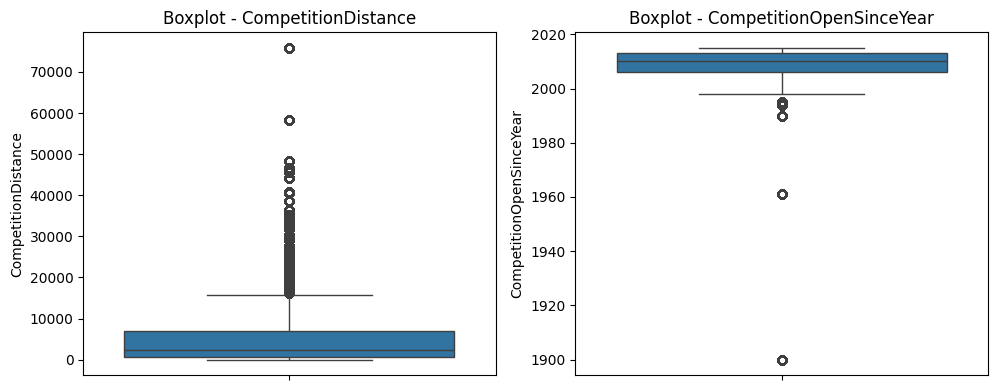

Se encontraron 2 variables numéricas.


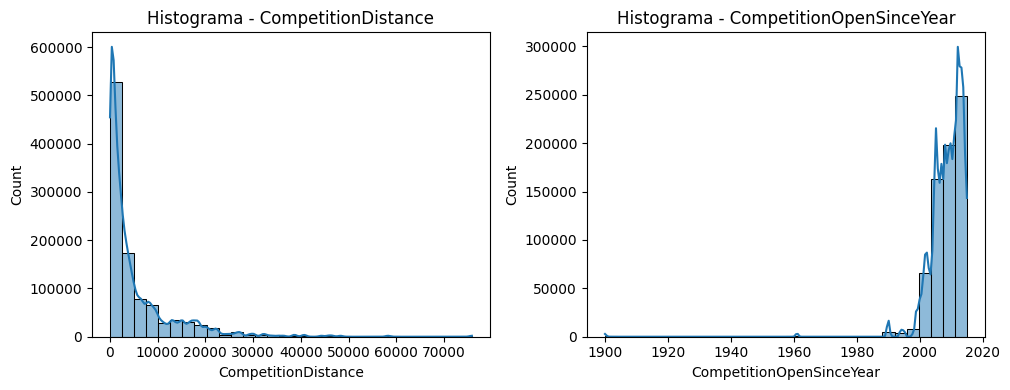

In [ ]:
# BoxPlot e histogramas de train
cols_boxplot = [
    'CompetitionDistance',
    'CompetitionOpenSinceYear'
]

boxplots(train[cols_boxplot],3)  # donde 'df' es tu DataFrame
histograms(train[cols_boxplot],3)  # donde 'df' es tu DataFrame

## Variables categóricas

In [ ]:
# Función para graficar varias variables categóricas en gráficos de barras
def plot_multiple_category_distributions(df, columns, charts_per_row=2):
    """
    Grafica proporciones de múltiples variables categóricas en forma de barras.

    Parámetros:
    - df: DataFrame
    - columns: lista de columnas categóricas a graficar
    - charts_per_row: cuántos gráficos mostrar por fila
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import math

    sns.set(style="whitegrid")

    n = len(columns)
    rows = math.ceil(n / charts_per_row)

    fig, axes = plt.subplots(rows, charts_per_row, figsize=(charts_per_row * 5, rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        prop = df[col].value_counts(normalize=True).sort_values(ascending=False)
        sns.barplot(x=prop.index, y=prop.values, ax=axes[i])
        axes[i].set_title(f'{col}')
        axes[i].set_ylabel('Proporción')
        axes[i].set_xlabel('')
        for j, v in enumerate(prop.values):
            axes[i].text(j, v + 0.01, f'{v:.1%}', ha='center')
        axes[i].set_ylim(0, prop.values.max() + 0.1)

    # Elimina ejes vacíos si hay más subplots que columnas
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

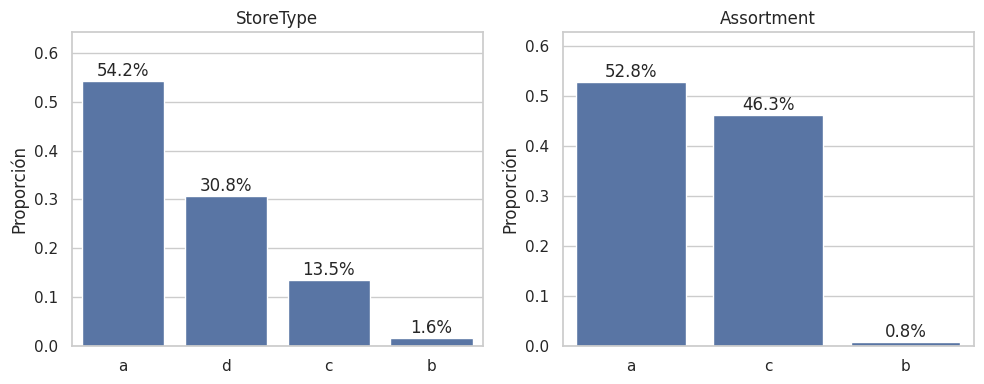

In [ ]:
plot_multiple_category_distributions(train, [
    'StoreType',
    'Assortment',
], charts_per_row=2)

## Variables Booleanas

## Variable Objetivo

In [ ]:
# Convertimos la columna 'Date' a tipo datetime
train['Date'] = pd.to_datetime(train['Date'])

# Extraemos componentes temporales
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Week'] = train['Date'].dt.isocalendar().week
train['IsWeekend'] = (train['DayOfWeek'] >= 5).astype(int)
train['Day'] = train['Date'].dt.day
train['DayOfYear'] = train['Date'].dt.dayofyear
train['IsMonthStart'] = train['Date'].dt.is_month_start.astype(int)
train['IsMonthEnd'] = train['Date'].dt.is_month_end.astype(int)

In [ ]:
# Convertimos la columna 'Date' a tipo datetime
test['Date'] = pd.to_datetime(test['Date'])

# Extraemos componentes temporales
test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month
test['Week'] = test['Date'].dt.isocalendar().week
test['Day'] = test['Date'].dt.day
test['DayOfYear'] = test['Date'].dt.dayofyear
test['IsMonthStart'] = test['Date'].dt.is_month_start.astype(int)
test['IsMonthEnd'] = test['Date'].dt.is_month_end.astype(int)

# Aseguramos 'DayOfWeek' y creamos 'IsWeekend'
test['IsWeekend'] = (test['DayOfWeek'] >= 5).astype(int)


### Series normalizadas

In [ ]:
# Función completa para graficar series normalizadas: original, primera y segunda derivada
def plot_all_normalized_series(train):
    import matplotlib.pyplot as plt

    # Aseguramos que la columna 'Date' esté en formato datetime
    train['Date'] = pd.to_datetime(train['Date'])

    # Agrupar por fecha y sumar ventas y clientes
    daily = train.groupby('Date')[['Sales', 'Customers']].sum().sort_index()

    # MEDIA MÓVIL (serie original suavizada)
    smoothed = daily.rolling(window=7).mean()
    sales_norm = (smoothed['Sales'] - smoothed['Sales'].min()) / (smoothed['Sales'].max() - smoothed['Sales'].min())
    customers_norm = (smoothed['Customers'] - smoothed['Customers'].min()) / (smoothed['Customers'].max() - smoothed['Customers'].min())

    # PRIMERA DERIVADA (variación diaria)
    first_diff = daily.diff()
    first_diff_smoothed = first_diff.rolling(window=7).mean()
    sales_diff_norm = (first_diff_smoothed['Sales'] - first_diff_smoothed['Sales'].min()) / (first_diff_smoothed['Sales'].max() - first_diff_smoothed['Sales'].min())
    customers_diff_norm = (first_diff_smoothed['Customers'] - first_diff_smoothed['Customers'].min()) / (first_diff_smoothed['Customers'].max() - first_diff_smoothed['Customers'].min())

    # SEGUNDA DERIVADA (aceleración)
    second_diff = first_diff.diff()
    second_diff_smoothed = second_diff.rolling(window=7).mean()
    sales_dd_norm = (second_diff_smoothed['Sales'] - second_diff_smoothed['Sales'].min()) / (second_diff_smoothed['Sales'].max() - second_diff_smoothed['Sales'].min())
    customers_dd_norm = (second_diff_smoothed['Customers'] - second_diff_smoothed['Customers'].min()) / (second_diff_smoothed['Customers'].max() - second_diff_smoothed['Customers'].min())

    # ==== GRÁFICO 1: Serie suavizada ====
    fig, ax1 = plt.subplots(figsize=(10, 3))
    ax1.plot(smoothed.index, sales_norm, color='tab:blue', label='Ventas (normalizado)')
    ax1.set_ylabel('Ventas (normalizado)', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax2 = ax1.twinx()
    ax2.plot(smoothed.index, customers_norm, color='tab:orange', linestyle='--', label='Clientes (normalizado)')
    ax2.set_ylabel('Clientes (normalizado)', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax1.set_title('Ventas y Clientes - Media Móvil 7 días (normalizado)')
    ax1.set_xlabel('Fecha')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ==== GRÁFICO 2: Primera derivada ====
    fig, ax1 = plt.subplots(figsize=(10, 3))
    ax1.plot(first_diff_smoothed.index, sales_diff_norm, color='tab:blue', label='Δ Ventas')
    ax1.set_ylabel('Δ Ventas (normalizado)', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax2 = ax1.twinx()
    ax2.plot(first_diff_smoothed.index, customers_diff_norm, color='tab:orange', linestyle='--', label='Δ Clientes')
    ax2.set_ylabel('Δ Clientes (normalizado)', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax1.set_title('Variación diaria (1ª derivada) - Media Móvil 7 días (normalizado)')
    ax1.set_xlabel('Fecha')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ==== GRÁFICO 3: Segunda derivada ====
    fig, ax1 = plt.subplots(figsize=(10, 3))
    ax1.plot(second_diff_smoothed.index, sales_dd_norm, color='tab:blue', label='Δ² Ventas')
    ax1.set_ylabel('Δ² Ventas (normalizado)', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax2 = ax1.twinx()
    ax2.plot(second_diff_smoothed.index, customers_dd_norm, color='tab:orange', linestyle='--', label='Δ² Clientes')
    ax2.set_ylabel('Δ² Clientes (normalizado)', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax1.set_title('Aceleración (2ª derivada) - Media Móvil 7 días (normalizado)')
    ax1.set_xlabel('Fecha')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


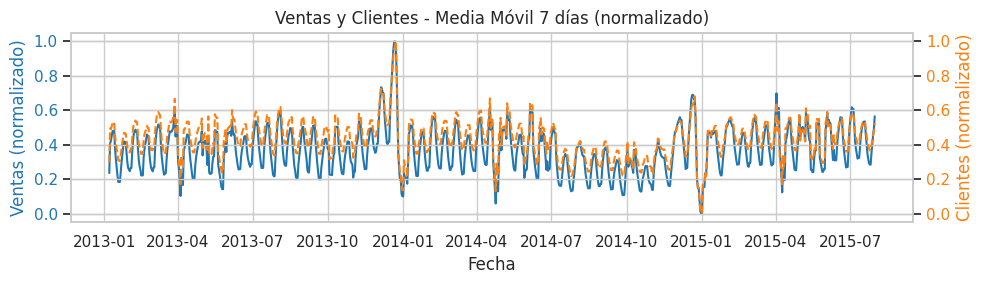

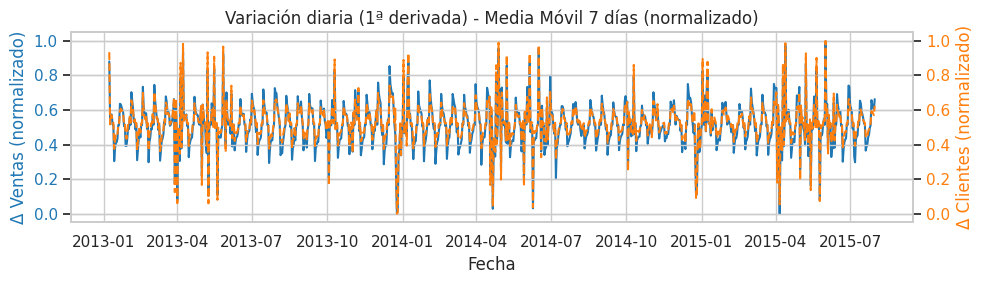

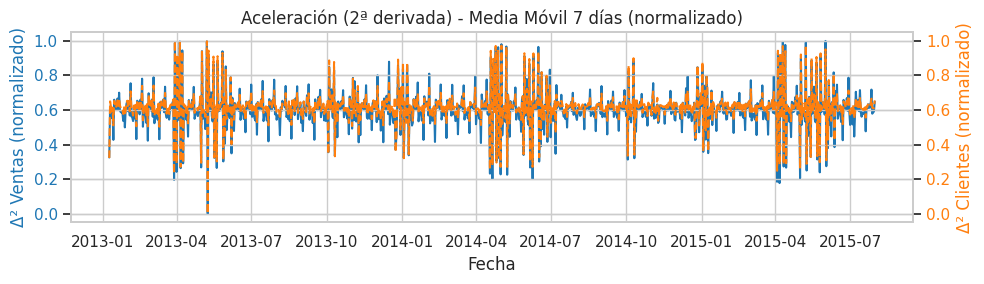

In [ ]:
plot_all_normalized_series(train)

### Distribución de ventas por día de la semana

In [ ]:
# Añade la columna 'DayOfWeek_str' con el nombre del día de la semana
train['DayOfWeek_str'] = pd.to_datetime(train['Date']).dt.day_name()
test['DayOfWeek_str'] = pd.to_datetime(test['Date']).dt.day_name()

In [ ]:
# Agrupa y suma Sales y Customers por día de la semana
sales_summary = train.groupby('DayOfWeek_str')[['Sales', 'Customers']].sum()

# Ordena los días de la semana en orden natural
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sales_summary = sales_summary.reindex(ordered_days)

# Formatea los números con separadores de miles
sales_summary_formatted = sales_summary.applymap(lambda x: f"{int(x):,}".replace(",", "."))

# Muestra el resumen formateado
print("\nVentas y clientes totales por día de la semana:\n")
print(sales_summary_formatted)


Ventas y clientes totales por día de la semana:

                       Sales    Customers
DayOfWeek_str                            
Monday         1.130.203.012  117.675.012
Tuesday        1.020.411.930  110.848.063
Wednesday        954.962.863  105.117.642
Thursday         911.177.709  101.732.938
Friday           980.555.941  108.384.820
Saturday         846.317.735   95.103.854
Sunday            29.551.433    5.179.426


<ipython-input-24-a1d7715180be>:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sales_summary_formatted = sales_summary.applymap(lambda x: f"{int(x):,}".replace(",", "."))


In [ ]:
# Eliminamos la columna 'DayOfWeek_str' de train y test
train.drop(columns=['DayOfWeek_str'], inplace=True)
test.drop(columns=['DayOfWeek_str'], inplace=True)

In [ ]:
def plot_box_and_dual_bar_by_dayofweek(df, variables):
    """
    Grafica barras y línea normalizadas por día de la semana,
    sin introducir días artificiales con valor cero (como Sunday si no aparece).
    """

    import matplotlib.pyplot as plt

    var1, var2 = variables

    # Validación
    if len(variables) != 2:
        raise ValueError("Debes proporcionar exactamente dos variables (ej: ['Sales', 'Customers'])")

    # Preprocesado
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df['DayOfWeek'] = df['Date'].dt.day_name()

    # Agrupar por día
    resumen = df.groupby('DayOfWeek')[[var1, var2]].sum()

    # Eliminar días sin datos (ambas variables a cero)
    resumen = resumen[(resumen[var1] > 0) & (resumen[var2] > 0)]

    # Ordenar según los días presentes
    ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    resumen = resumen.reindex([d for d in ordered_days if d in resumen.index])

    # Normalizar
    resumen_norm = (resumen - resumen.min()) / (resumen.max() - resumen.min())

    # Gráfico
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.bar(resumen_norm.index, resumen_norm[var1], color='tab:blue', label=var1)
    ax1.set_ylabel(f'{var1} (normalizado)', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(0, 1)
    ax1.set_xlabel('Día de la semana')
    ax1.set_xticklabels(resumen_norm.index, rotation=45)

    ax2 = ax1.twinx()
    ax2.plot(resumen_norm.index, resumen_norm[var2], color='tab:orange', marker='o', linestyle='--', label=var2)
    ax2.set_ylabel(f'{var2} (normalizado)', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax2.set_ylim(0, 1)

    plt.title(f'{var1} (barras) y {var2} (línea) por día de la semana (normalizados)')
    fig.tight_layout()
    plt.show()

<ipython-input-26-7058411ca961>:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(resumen_norm.index, rotation=45)


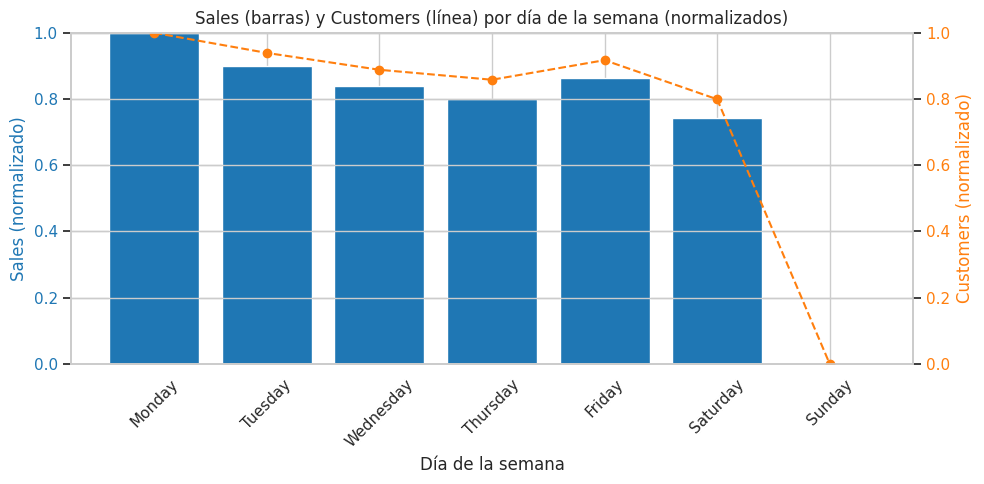

In [ ]:
plot_box_and_dual_bar_by_dayofweek(train, ['Sales', 'Customers'])

# 4. FEATURE ENGINEERING

## Codificación de Variables Categóricas

In [ ]:
# Mostrar columnas tipo object
object_cols = train.select_dtypes(include='object').columns
print("Columnas tipo object:")
print(object_cols.tolist())

Columnas tipo object:
['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']


### Codificación DayOfWeek

In [ ]:
# Tipo de variable y valores únicos de 'DayOfWeek' en train
print("train['DayOfWeek'] →", train['DayOfWeek'].dtype)
print("Valores únicos en train:", train['DayOfWeek'].unique())

# Tipo de variable y valores únicos de 'DayOfWeek' en test
print("test['DayOfWeek'] →", test['DayOfWeek'].dtype)
print("Valores únicos en test:", test['DayOfWeek'].unique())

train['DayOfWeek'] → int64
Valores únicos en train: [5 4 3 2 1 7 6]
test['DayOfWeek'] → int64
Valores únicos en test: [4 3 2 1 7 6 5]


In [ ]:
# Encoding cíclico para DayOfWeek (0 a 6)
train['DayOfWeek_sin'] = np.sin(2 * np.pi * train['DayOfWeek'] / 7)
train['DayOfWeek_cos'] = np.cos(2 * np.pi * train['DayOfWeek'] / 7)

# Encoding cíclico para DayOfWeek (0 a 6)
test['DayOfWeek_sin'] = np.sin(2 * np.pi * test['DayOfWeek'] / 7)
test['DayOfWeek_cos'] = np.cos(2 * np.pi * test['DayOfWeek'] / 7)

In [ ]:
# Eliminamos la columna 'DayOfWeek' de train y test por estar representada ya en forma cíclica
train = train.drop(['DayOfWeek'], axis=1)
test = test.drop(['DayOfWeek'], axis=1)

In [ ]:
# Mostrar columnas tipo object
object_cols = train.select_dtypes(include='object').columns
print("Columnas tipo object:")
print(object_cols.tolist())

Columnas tipo object:
['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']


### StateHoliday

In [ ]:
# Imprime los valores únicos de la columna 'StateHoliday'
print(train['StateHoliday'].unique())
# Imprime los valores únicos de la columna 'StateHoliday'
print(test['StateHoliday'].unique())

['0' 'a' 'b' 'c' 0]
['0' 'a']


In [ ]:
# Reemplazar los valores 0 por el string 'NA' en la columna 'StateHoliday'
train['StateHoliday'] = train['StateHoliday'].replace(0, 'NA')
train['StateHoliday'] = train['StateHoliday'].replace('0', 'NA')

# Ver los tipos únicos de datos en la columna 'StateHoliday'
print(train['StateHoliday'].map(type).value_counts())

# Mostrar los valores únicos en la columna 'StateHoliday'
print(train['StateHoliday'].unique())

StateHoliday
<class 'str'>    1017209
Name: count, dtype: int64
['NA' 'a' 'b' 'c']


In [ ]:
# Reemplazar los valores 0 por el string 'NA' en la columna 'StateHoliday'
test['StateHoliday'] = test['StateHoliday'].replace(0, 'NA')
test['StateHoliday'] = test['StateHoliday'].replace('0', 'NA')

# Ver los tipos únicos de datos en la columna 'StateHoliday'
print(test['StateHoliday'].map(type).value_counts())

# Mostrar los valores únicos en la columna 'StateHoliday'
print(test['StateHoliday'].unique())

StateHoliday
<class 'str'>    41088
Name: count, dtype: int64
['NA' 'a']


### Store Type, Assortment y StateHoliday

In [ ]:
cat_cols = ['StoreType', 'Assortment','StateHoliday']  # ajusta según tus columnas
for col in cat_cols:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

### PromoInterval

In [ ]:
# Mostrar valores únicos de 'PromoInterval'
print(train['PromoInterval'].unique())

[nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']


In [ ]:
# Reemplazar NaN por 'None' (indica que la tienda no participa en promos continuas)
train['PromoInterval'] = train['PromoInterval'].fillna('None')
# Reemplazar NaN por 'None' (indica que la tienda no participa en promos continuas)
test['PromoInterval'] = test['PromoInterval'].fillna('None')

In [ ]:
# Extraemos el mes actual en formato corto (ej. 'Jan', 'Feb', etc.)
train['MonthStr'] = train['Date'].dt.month_name().str[:3]
test['MonthStr'] = test['Date'].dt.month_name().str[:3]

# Indicamos si el mes está incluido en el texto de 'PromoInterval'
train['IsPromoMonth'] = train.apply(
    lambda row: 1 if row['MonthStr'] in row['PromoInterval'] else 0,
    axis=1
)
test['IsPromoMonth'] = test.apply(
    lambda row: 1 if row['MonthStr'] in row['PromoInterval'] else 0,
    axis=1
)

# Eliminamos columnas auxiliares
train.drop(columns=['PromoInterval', 'MonthStr'], inplace=True)
test.drop(columns=['PromoInterval', 'MonthStr'], inplace=True)

In [ ]:
# Mostrar valores únicos de 'PromoInterval'
print(train['IsPromoMonth'].unique())
# Mostrar valores únicos de 'PromoInterval'
print(test['IsPromoMonth'].unique())

[0 1]
[0 1]


In [ ]:
# # OPCIONAL: One-hot encoding de 'PromoInterval' si prefieres mantener los patrones de promoción diferenciados

# # Sustituimos NaN por 'None' para codificarlo como una categoría válida
# train['PromoInterval'] = train['PromoInterval'].fillna('None')

# # Aplicamos one-hot encoding a los patrones de promoción
# train = pd.get_dummies(train, columns=['PromoInterval'], prefix='PromoInterval')

# # Ejemplo de columnas creadas:
# # - PromoInterval_None
# # - PromoInterval_Jan_Apr_Jul_Oct
# # - PromoInterval_Feb_May_Aug_Nov
# # - PromoInterval_Mar_Jun_Sept_Dec


### PromoSince y CompetitionSince

In [ ]:
# Combinamos 'Promo2SinceYear' y 'Promo2SinceWeek' en una sola columna tipo fecha
train['Promo2Since'] = pd.to_datetime(
    train['Promo2SinceYear'].fillna(1900).astype(int).astype(str) + '-' +
    train['Promo2SinceWeek'].fillna(1).astype(int).astype(str) + '-1',
    format='%Y-%W-%w', errors='coerce'
)
# Combinamos 'Promo2SinceYear' y 'Promo2SinceWeek' en una sola columna tipo fecha
test['Promo2Since'] = pd.to_datetime(
    test['Promo2SinceYear'].fillna(1900).astype(int).astype(str) + '-' +
    test['Promo2SinceWeek'].fillna(1).astype(int).astype(str) + '-1',
    format='%Y-%W-%w', errors='coerce'
)

# Combinamos 'CompetitionOpenSinceYear' y 'CompetitionOpenSinceMonth' en una sola columna tipo fecha
train['CompetitionOpenSince'] = pd.to_datetime(
    dict(
        year=train['CompetitionOpenSinceYear'].fillna(1900).astype(int),
        month=train['CompetitionOpenSinceMonth'].fillna(1).astype(int),
        day=1
    )
)
# Combinamos 'CompetitionOpenSinceYear' y 'CompetitionOpenSinceMonth' en una sola columna tipo fecha
test['CompetitionOpenSince'] = pd.to_datetime(
    dict(
        year=test['CompetitionOpenSinceYear'].fillna(1900).astype(int),
        month=test['CompetitionOpenSinceMonth'].fillna(1).astype(int),
        day=1
    )
)

In [ ]:
# Tiempo desde que comenzó Promo2 (en semanas)
train['Promo2OpenWeeks'] = ((train['Date'] - train['Promo2Since']) / np.timedelta64(1, 'W')).clip(lower=0)
test['Promo2OpenWeeks'] = ((test['Date'] - test['Promo2Since']) / np.timedelta64(1, 'W')).clip(lower=0)

# Aproximamos los meses como 30 días
train['CompetitionOpenTimeMonths'] = ((train['Date'] - train['CompetitionOpenSince']).dt.days / 30).clip(lower=0)
test['CompetitionOpenTimeMonths'] = ((test['Date'] - test['CompetitionOpenSince']).dt.days / 30).clip(lower=0)

In [ ]:
# Eliminamos las columnas originales que ya han sido sustituidas por variables derivadas
train.drop(columns=[
    'Promo2SinceYear',
    'Promo2SinceWeek',
    'Promo2Since',
    'CompetitionOpenSinceYear',
    'CompetitionOpenSinceMonth',
    'CompetitionOpenSince'
], inplace=True)

# Eliminamos las columnas originales que ya han sido sustituidas por variables derivadas
test.drop(columns=[
    'Promo2SinceYear',
    'Promo2SinceWeek',
    'Promo2Since',
    'CompetitionOpenSinceYear',
    'CompetitionOpenSinceMonth',
    'CompetitionOpenSince'
], inplace=True)

## Valores Nulos

In [ ]:
# Ajustar la opción de visualización para mostrar todas las columnas en una sola línea
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)

# Filtrar columnas con valores nulos en train o test
nule_cols = train.columns[train.isnull().any()].union(test.columns[test.isnull().any()])

# Crear DataFrame con la información de nulos
nule_cols_df = pd.DataFrame({
    "Column": nule_cols,
    "Dtype": [train[col].dtype if col in train.columns else test[col].dtype for col in nule_cols],
    "Null_Percentage_Train": [train[col].isnull().mean() * 100 if col in train.columns else 0 for col in nule_cols],
    "Null_Percentage_Test": [test[col].isnull().mean() * 100 if col in test.columns else 0 for col in nule_cols]
})

# Mostrar el DataFrame
print(nule_cols_df)

                Column    Dtype  Null_Percentage_Train  Null_Percentage_Test
0  CompetitionDistance  float64                0.25973              0.233645
1                 Open    int64                0.00000              0.026772


### Competition Distance

In [ ]:
# Imputamos los valores nulos de 'CompetitionDistance' con un valor alto (indicando que no hay competencia cercana)
# Por ejemplo, 100000 para simular "sin competencia"
train['CompetitionDistance'] = train['CompetitionDistance'].fillna(100000)
test['CompetitionDistance'] = test['CompetitionDistance'].fillna(100000)

### Open

In [ ]:
# Imprime los valores únicos de la columna 'Open'
print(train['Open'].unique())

[1 0]


In [ ]:
# Imputamos valores nulos de 'Open' con 0
train['Open'] = train['Open'].fillna(0)
test['Open'] = test['Open'].fillna(0)

## Comprobación Final del Dataset

In [ ]:
# Unificamos columnas para comparar ambas estructuras
all_columns = sorted(set(train.columns).union(set(test.columns)))

# Construimos info de train
info_train = {
    col: {
        'tipo_dato_train': str(train[col].dtype) if col in train.columns else 'ERROR',
        'porc_nulos_train': round(train[col].isnull().mean() * 100, 2) if col in train.columns else 'ERROR'
    } for col in all_columns
}

# Construimos info de test
for col in all_columns:
    info_train[col].update({
        'tipo_dato_test': str(test[col].dtype) if col in test.columns else 'ERROR',
        'porc_nulos_test': round(test[col].isnull().mean() * 100, 2) if col in test.columns else 'ERROR'
    })

# Convertimos a DataFrame
null_info_comparada = pd.DataFrame.from_dict(info_train, orient='index').reset_index().rename(columns={'index': 'columna'})

# Mostramos tabla unificada
print(null_info_comparada)


                      columna tipo_dato_train porc_nulos_train  tipo_dato_test porc_nulos_test
0                  Assortment        category              0.0        category             0.0
1         CompetitionDistance         float64              0.0         float64             0.0
2   CompetitionOpenTimeMonths         float64              0.0         float64             0.0
3                   Customers           int64              0.0           ERROR           ERROR
4                        Date  datetime64[ns]              0.0  datetime64[ns]             0.0
5                         Day           int32              0.0           int32             0.0
6               DayOfWeek_cos         float64              0.0         float64             0.0
7               DayOfWeek_sin         float64              0.0         float64             0.0
8                   DayOfYear           int32              0.0           int32             0.0
9                          Id           ERROR     

# 4. LIMPIEZA DE DATOS

In [ ]:
# eliminar del registro las tiendas cerradas
train = train[train['Open'] == 1]

In [ ]:
# eliminar del registro días sin ventas
train = train[train['Sales'] > 0]

# 5. IMPLEMENTACIÓN DE MODELO

In [ ]:
import datetime

# Cargar historial si ya existe, o crear uno nuevo
try:
    historial_modelos = pd.read_csv('resultados_modelos.csv')
except FileNotFoundError:
    historial_modelos = pd.DataFrame(columns=['modelo', 'rmspe', 'semanas_validacion', 'fecha', 'params'])

In [ ]:
#
def registrar_resultado(modelo_nombre, rmspe_val, semanas_val, model=None, params_manual=None):
    global historial_modelos

    # Extraemos los parámetros si el modelo tiene .get_params(), o usamos los que se pasen manualmente
    if model is not None and hasattr(model, 'get_params'):
        params = model.get_params()
    elif params_manual is not None:
        params = params_manual
    else:
        params = {}

    nueva_fila = {
        'modelo': modelo_nombre,
        'rmspe': round(rmspe_val, 5),
        'semanas_validacion': semanas_val,
        'fecha': datetime.datetime.now().strftime("%Y-%m-%d %H:%M"),
        'params': str(params)
    }

    historial_modelos = pd.concat([historial_modelos, pd.DataFrame([nueva_fila])], ignore_index=True)
    historial_modelos.to_csv('resultados_modelos.csv', index=False)
    print(f"✅ Modelo '{modelo_nombre}' guardado en historial.")

In [ ]:
# ordenamos train y reseteamos índice
train = train.sort_values('Date').reset_index(drop=True)

# Definimos X e y, excluyendo 'Sales' de X
y = train['Sales']
X = train.drop(['Date','Customers','Sales'], axis=1)

# Eliminamos columna 'Id' de test
X_test = test.drop(['Id', 'Date'], axis=1)

In [ ]:
# # Obtenemos todas las tiendas únicas
# stores = X['Store'].unique()

# # Creamos un diccionario para guardar los splits por tienda
# splits_por_tienda = {}

# # Iteramos sobre cada tienda y generamos splits temporales independientes
# for store in stores:
#     # Obtenemos los índices correspondientes a esa tienda
#     idx_store = X[X['Store'] == store].index

#     # Creamos el TimeSeriesSplit para esa tienda
#     tscv = TimeSeriesSplit(n_splits=3)

#     # Guardamos los splits (pares de índices de train/test) para esa tienda
#     splits_por_tienda[store] = list(tscv.split(idx_store))

In [ ]:
# # TimeSeriesSplit para series temporales (ej: 5 splits)
# tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
# Función RMSPE para evaluación
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Versión compatible con LightGBM
def lgb_rmspe(y_pred, dataset):
    y_true = dataset.get_label()
    rmspe_score = rmspe(y_true, y_pred)
    return 'RMSPE', rmspe_score, False  # False = cuanto más bajo, mejor

# Función RMSPE para evaluación en XGBoost
def rmspe_xgboost(y_pred, dtrain):
    y_true = dtrain.get_label()
    rmspe_score = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return 'RMSPE', rmspe_score

In [ ]:
# Asegúrate de tener la columna Date en datetime
train['Date'] = pd.to_datetime(train['Date'])

nweeks = 6
# Cortamos las últimas 6 semanas reales según fecha
fecha_corte = train['Date'].max() - pd.Timedelta(weeks=nweeks)

# Creamos máscaras temporales bien definidas
train_mask = train['Date'] < fecha_corte
val_mask = train['Date'] >= fecha_corte

In [ ]:
# definimos conjunto de train y test
X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]

In [ ]:
train['Date']

,Date
0,2013-01-01
1,2013-01-01
2,2013-01-01
3,2013-01-01
4,2013-01-01
...,...
844333,2015-07-31
844334,2015-07-31
844335,2015-07-31
844336,2015-07-31


## LightGBM 1

In [ ]:
# Entrenamos un primer modelo básico con LightGBM sobre un subset de variables relevantes

# Dataset para LightGBM
train_set = lgb.Dataset(X_train, label=y_train)
val_set = lgb.Dataset(X_val, label=y_val)

# Entrenamiento del modelo
model_LightGBM_1_b = lgb.train(
    params={
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'seed': 42
    },
    train_set=train_set,
    valid_sets=[train_set, val_set],
    num_boost_round=1000,
)

# Predicción y evaluación con RMSPE
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2))

y_pred = model_LightGBM_1_b.predict(X_val)
score = rmspe(y_val[y_val != 0], y_pred[y_val != 0])
print(f'RMSPE: {score:.4f}')

RMSPE: 0.1839


In [ ]:
registrar_resultado(
    modelo_nombre='LightGBM_1',
    rmspe_val=score,
    semanas_val=nweeks,
    params_manual={
        'objective': 'regression',
        'metric': 'rmse',
        'seed': 42,
        'learning_rate': 0.05,
        'max_depth': -1
    }
)

✅ Modelo 'LightGBM_1' guardado en historial.


<ipython-input-53-105dc1d2e8a3>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  historial_modelos = pd.concat([historial_modelos, pd.DataFrame([nueva_fila])], ignore_index=True)


## LightGBM 2 -- log

In [ ]:
# Transformamos la variable objetivo
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

# Datasets para LightGBM
train_set = lgb.Dataset(X_train, label=y_train_log)
val_set = lgb.Dataset(X_val, label=y_val_log)

# Entrenamiento
model_LightGBM_2_b = lgb.train(
    params={
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'seed': 42
    },
    train_set=train_set,
    valid_sets=[train_set, val_set],
    num_boost_round=1000,
)

# Predicción y evaluación en escala original
y_pred_log = model_LightGBM_2_b.predict(X_val)
y_pred = np.expm1(y_pred_log)
y_val_original = np.expm1(y_val_log)

# RMSPE con y ≠ 0
def rmspe(y_true, y_pred):
    mask = y_true != 0
    return np.sqrt(np.mean(((y_true[mask] - y_pred[mask]) / y_true[mask]) ** 2))

score = rmspe(y_val_original, y_pred)
print(f'RMSPE: {score:.4f}')

RMSPE: 0.1528


In [ ]:
registrar_resultado(
    modelo_nombre='LightGBM_2',
    rmspe_val=score,
    semanas_val=nweeks,
    params_manual={
        'objective': 'regression',
        'metric': 'rmse',
        'seed': 42,
        'learning_rate': 0.05,
        'max_depth': -1
    }
)

✅ Modelo 'LightGBM_2' guardado en historial.


## LightGBM y Optuna

In [ ]:
# Función base con posibilidad de pasar rangos dinámicamente
# Optuna usará GPU durante el tuning con LightGBM
def run_optuna_optimization(param_ranges, n_trials=20, boost_rounds=500):
    def objective(trial):
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'device': 'cpu',  # Activamos GPU
            'gpu_platform_id': 0,
            'gpu_device_id': 0,
            'seed': 42,
            'learning_rate': trial.suggest_float('learning_rate', param_ranges['learning_rate'][0], param_ranges['learning_rate'][1]),
            'num_leaves': trial.suggest_int('num_leaves', param_ranges['num_leaves'][0], param_ranges['num_leaves'][1]),
            'max_depth': trial.suggest_int('max_depth', param_ranges['max_depth'][0], param_ranges['max_depth'][1]),
            'min_child_samples': trial.suggest_int('min_child_samples', param_ranges['min_child_samples'][0], param_ranges['min_child_samples'][1]),
            'subsample': trial.suggest_float('subsample', param_ranges['subsample'][0], param_ranges['subsample'][1]),
            'colsample_bytree': trial.suggest_float('colsample_bytree', param_ranges['colsample_bytree'][0], param_ranges['colsample_bytree'][1]),
        }


        dtrain = lgb.Dataset(X_train, label=y_train_log)
        dval = lgb.Dataset(X_val, label=y_val_log)

        model = lgb.train(
            params,
            dtrain,
            valid_sets=[dval],
            num_boost_round=boost_rounds,
            callbacks=[
                lgb.early_stopping(20),
                lgb.log_evaluation(0)],
        )

        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val_log, y_pred))
        return rmse

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    return study

# FASE 1 – Exploración amplia
print("🔍 Fase 1: Exploración general...")

ranges_fase1 = {
    'learning_rate': (0.05, 0.3),
    'num_leaves': (20, 100),
    'max_depth': (5, 25),
    'min_child_samples': (10, 100),
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.6, 1.0),
}

print("📦 Rango de parámetros:", ranges_fase1)
study_fase1 = run_optuna_optimization(ranges_fase1, n_trials=20, boost_rounds=300)
print("✅ Mejores parámetros Fase 1:", study_fase1.best_params)

# FASE 2 – Búsqueda refinada
print("\n🎯 Fase 2: Refinamiento...")

ranges_fase2 = {
    'learning_rate': (0.01, 0.08),
    'num_leaves': (max(20, study_fase1.best_params['num_leaves'] - 20), study_fase1.best_params['num_leaves'] + 20),
    'max_depth': (max(5, study_fase1.best_params['max_depth'] - 5), study_fase1.best_params['max_depth'] + 5),
    'min_child_samples': (study_fase1.best_params['min_child_samples'] - 10, study_fase1.best_params['min_child_samples'] + 10),
    'subsample': (max(0.6, study_fase1.best_params['subsample'] - 0.1), min(1.0, study_fase1.best_params['subsample'] + 0.1)),
    'colsample_bytree': (max(0.6, study_fase1.best_params['colsample_bytree'] - 0.1), min(1.0, study_fase1.best_params['colsample_bytree'] + 0.1)),
}
study_fase2 = run_optuna_optimization(ranges_fase2, n_trials=30, boost_rounds=1000)
print("✅ Mejores parámetros Fase 2:", study_fase2.best_params)

# (Opcional) FASE 3 – Ajuste fino si quieres afinar más
# Puedes copiar el mismo esquema anterior, acotando aún más los rangos

# Resultado final
mejores_parametros = study_fase2.best_params
print("\n🏁 Parámetros finales óptimos:", mejores_parametros)


[I 2025-03-28 20:35:47,040] A new study created in memory with name: no-name-9a190fe6-1150-403f-bc78-4001f659d6c7


🔍 Fase 1: Exploración general...
📦 Rango de parámetros: {'learning_rate': (0.05, 0.3), 'num_leaves': (20, 100), 'max_depth': (5, 25), 'min_child_samples': (10, 100), 'subsample': (0.6, 1.0), 'colsample_bytree': (0.6, 1.0)}
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 0.141899


[I 2025-03-28 20:36:11,898] Trial 0 finished with value: 0.14189856917769597 and parameters: {'learning_rate': 0.205627677686815, 'num_leaves': 95, 'max_depth': 24, 'min_child_samples': 80, 'subsample': 0.665457128314155, 'colsample_bytree': 0.8564357140382614}. Best is trial 0 with value: 0.14189856917769597.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[299]	valid_0's rmse: 0.157279


[I 2025-03-28 20:36:42,961] Trial 1 finished with value: 0.15727948453605325 and parameters: {'learning_rate': 0.10622426601505615, 'num_leaves': 71, 'max_depth': 22, 'min_child_samples': 18, 'subsample': 0.9022020786799565, 'colsample_bytree': 0.6344531979475517}. Best is trial 0 with value: 0.14189856917769597.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 0.159654


[I 2025-03-28 20:37:12,199] Trial 2 finished with value: 0.15965419662365313 and parameters: {'learning_rate': 0.13103677222680893, 'num_leaves': 55, 'max_depth': 16, 'min_child_samples': 38, 'subsample': 0.8145283317802994, 'colsample_bytree': 0.6233342325555863}. Best is trial 0 with value: 0.14189856917769597.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 0.172605


[I 2025-03-28 20:37:35,293] Trial 3 finished with value: 0.172605357390006 and parameters: {'learning_rate': 0.1474642169551304, 'num_leaves': 33, 'max_depth': 7, 'min_child_samples': 88, 'subsample': 0.8096745948135042, 'colsample_bytree': 0.8953612184647848}. Best is trial 0 with value: 0.14189856917769597.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 0.152817


[I 2025-03-28 20:38:02,843] Trial 4 finished with value: 0.152816541534552 and parameters: {'learning_rate': 0.12711026045397128, 'num_leaves': 73, 'max_depth': 20, 'min_child_samples': 74, 'subsample': 0.8773211726096987, 'colsample_bytree': 0.655878050797632}. Best is trial 0 with value: 0.14189856917769597.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 0.153745


[I 2025-03-28 20:38:28,566] Trial 5 finished with value: 0.15374487755655933 and parameters: {'learning_rate': 0.1224269626086709, 'num_leaves': 69, 'max_depth': 16, 'min_child_samples': 88, 'subsample': 0.6833238988100887, 'colsample_bytree': 0.7530635121248489}. Best is trial 0 with value: 0.14189856917769597.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 0.174772


[I 2025-03-28 20:39:00,196] Trial 6 finished with value: 0.1747720711493056 and parameters: {'learning_rate': 0.06764762574740639, 'num_leaves': 88, 'max_depth': 9, 'min_child_samples': 83, 'subsample': 0.7101336310911187, 'colsample_bytree': 0.6514545991483192}. Best is trial 0 with value: 0.14189856917769597.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[299]	valid_0's rmse: 0.150848


[I 2025-03-28 20:39:23,290] Trial 7 finished with value: 0.15084799172965274 and parameters: {'learning_rate': 0.19645904162018207, 'num_leaves': 48, 'max_depth': 24, 'min_child_samples': 65, 'subsample': 0.7533295714249052, 'colsample_bytree': 0.8933480984365971}. Best is trial 0 with value: 0.14189856917769597.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 0.164569


[I 2025-03-28 20:39:44,283] Trial 8 finished with value: 0.1645688181333527 and parameters: {'learning_rate': 0.13408630150430628, 'num_leaves': 43, 'max_depth': 15, 'min_child_samples': 18, 'subsample': 0.9990685223880711, 'colsample_bytree': 0.7727643393680932}. Best is trial 0 with value: 0.14189856917769597.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[299]	valid_0's rmse: 0.145558


[I 2025-03-28 20:40:08,331] Trial 9 finished with value: 0.14555813899030165 and parameters: {'learning_rate': 0.1672342604284287, 'num_leaves': 66, 'max_depth': 23, 'min_child_samples': 58, 'subsample': 0.8178704556288411, 'colsample_bytree': 0.8348167471797037}. Best is trial 0 with value: 0.14189856917769597.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 0.138316


[I 2025-03-28 20:40:35,935] Trial 10 finished with value: 0.13831624704490095 and parameters: {'learning_rate': 0.26697387523492067, 'num_leaves': 98, 'max_depth': 12, 'min_child_samples': 100, 'subsample': 0.6071997538711937, 'colsample_bytree': 0.966359942880147}. Best is trial 10 with value: 0.13831624704490095.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 0.13979


[I 2025-03-28 20:41:00,267] Trial 11 finished with value: 0.13979009554552918 and parameters: {'learning_rate': 0.26929365739086636, 'num_leaves': 97, 'max_depth': 12, 'min_child_samples': 96, 'subsample': 0.6036929082068021, 'colsample_bytree': 0.975411258641869}. Best is trial 10 with value: 0.13831624704490095.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 0.141991


[I 2025-03-28 20:41:22,054] Trial 12 finished with value: 0.14199148186695668 and parameters: {'learning_rate': 0.2826532842217546, 'num_leaves': 100, 'max_depth': 11, 'min_child_samples': 100, 'subsample': 0.6181048809947999, 'colsample_bytree': 0.9962356918373999}. Best is trial 10 with value: 0.13831624704490095.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 0.143094


[I 2025-03-28 20:41:45,861] Trial 13 finished with value: 0.14309363118589896 and parameters: {'learning_rate': 0.28323830094313956, 'num_leaves': 83, 'max_depth': 12, 'min_child_samples': 100, 'subsample': 0.6257556929958786, 'colsample_bytree': 0.9938233306005679}. Best is trial 10 with value: 0.13831624704490095.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 0.139869


[I 2025-03-28 20:42:09,981] Trial 14 finished with value: 0.13986942653159615 and parameters: {'learning_rate': 0.2455025129170223, 'num_leaves': 81, 'max_depth': 12, 'min_child_samples': 42, 'subsample': 0.6006549693215526, 'colsample_bytree': 0.9456774279613517}. Best is trial 10 with value: 0.13831624704490095.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 0.172188


[I 2025-03-28 20:42:29,298] Trial 15 finished with value: 0.17218839566373273 and parameters: {'learning_rate': 0.24149244052033017, 'num_leaves': 22, 'max_depth': 5, 'min_child_samples': 99, 'subsample': 0.7346602145967726, 'colsample_bytree': 0.9460320730249002}. Best is trial 10 with value: 0.13831624704490095.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[292]	valid_0's rmse: 0.141036


[I 2025-03-28 20:42:53,593] Trial 16 finished with value: 0.1410364124185577 and parameters: {'learning_rate': 0.24732895798060545, 'num_leaves': 92, 'max_depth': 19, 'min_child_samples': 69, 'subsample': 0.6624300919213076, 'colsample_bytree': 0.9368000563263524}. Best is trial 10 with value: 0.13831624704490095.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 0.142207


[I 2025-03-28 20:43:21,264] Trial 17 finished with value: 0.14220700269937042 and parameters: {'learning_rate': 0.21814587669842825, 'num_leaves': 100, 'max_depth': 9, 'min_child_samples': 43, 'subsample': 0.7594008805911037, 'colsample_bytree': 0.7371612758749005}. Best is trial 10 with value: 0.13831624704490095.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 0.145136


[I 2025-03-28 20:43:46,547] Trial 18 finished with value: 0.1451364578226838 and parameters: {'learning_rate': 0.2969823645794625, 'num_leaves': 81, 'max_depth': 14, 'min_child_samples': 90, 'subsample': 0.6473616498172228, 'colsample_bytree': 0.702612867134302}. Best is trial 10 with value: 0.13831624704490095.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[288]	valid_0's rmse: 0.143974


[I 2025-03-28 20:44:08,207] Trial 19 finished with value: 0.14397350741652057 and parameters: {'learning_rate': 0.254778008737915, 'num_leaves': 87, 'max_depth': 10, 'min_child_samples': 56, 'subsample': 0.7030775095313815, 'colsample_bytree': 0.8149701381655994}. Best is trial 10 with value: 0.13831624704490095.
[I 2025-03-28 20:44:08,215] A new study created in memory with name: no-name-5329a279-6604-4c48-a2a4-7877be2ce768


✅ Mejores parámetros Fase 1: {'learning_rate': 0.26697387523492067, 'num_leaves': 98, 'max_depth': 12, 'min_child_samples': 100, 'subsample': 0.6071997538711937, 'colsample_bytree': 0.966359942880147}

🎯 Fase 2: Refinamiento...
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.174136


[I 2025-03-28 20:46:08,463] Trial 0 finished with value: 0.17413562208820593 and parameters: {'learning_rate': 0.013240471500617912, 'num_leaves': 117, 'max_depth': 14, 'min_child_samples': 91, 'subsample': 0.6343541370903315, 'colsample_bytree': 0.9422106120939201}. Best is trial 0 with value: 0.17413562208820593.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.144863


[I 2025-03-28 20:47:33,445] Trial 1 finished with value: 0.1448627048396425 and parameters: {'learning_rate': 0.0416403541572352, 'num_leaves': 89, 'max_depth': 15, 'min_child_samples': 91, 'subsample': 0.680598481928958, 'colsample_bytree': 0.9792398030926697}. Best is trial 1 with value: 0.1448627048396425.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.137147


[I 2025-03-28 20:48:58,785] Trial 2 finished with value: 0.13714704337823633 and parameters: {'learning_rate': 0.05167929012959826, 'num_leaves': 112, 'max_depth': 16, 'min_child_samples': 104, 'subsample': 0.6098337165837604, 'colsample_bytree': 0.8852833225352296}. Best is trial 2 with value: 0.13714704337823633.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.143724


[I 2025-03-28 20:50:36,439] Trial 3 finished with value: 0.1437235734335738 and parameters: {'learning_rate': 0.03598383318505359, 'num_leaves': 113, 'max_depth': 13, 'min_child_samples': 93, 'subsample': 0.7055208071615875, 'colsample_bytree': 0.9935236856462482}. Best is trial 2 with value: 0.13714704337823633.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.136191


[I 2025-03-28 20:52:02,062] Trial 4 finished with value: 0.1361905955292936 and parameters: {'learning_rate': 0.07176287040424931, 'num_leaves': 95, 'max_depth': 8, 'min_child_samples': 107, 'subsample': 0.6709153205228038, 'colsample_bytree': 0.8854583933233263}. Best is trial 4 with value: 0.1361905955292936.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.136497


[I 2025-03-28 20:53:23,582] Trial 5 finished with value: 0.13649680202995262 and parameters: {'learning_rate': 0.06702988848530547, 'num_leaves': 106, 'max_depth': 12, 'min_child_samples': 91, 'subsample': 0.6122372410619217, 'colsample_bytree': 0.944035252414391}. Best is trial 4 with value: 0.1361905955292936.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 0.137188


[I 2025-03-28 20:54:58,135] Trial 6 finished with value: 0.13718841095610718 and parameters: {'learning_rate': 0.06076873061629725, 'num_leaves': 86, 'max_depth': 17, 'min_child_samples': 94, 'subsample': 0.6209581157490761, 'colsample_bytree': 0.9379867027800048}. Best is trial 4 with value: 0.1361905955292936.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 0.133363


[I 2025-03-28 20:56:18,634] Trial 7 finished with value: 0.13336286443506046 and parameters: {'learning_rate': 0.07155166482645704, 'num_leaves': 107, 'max_depth': 12, 'min_child_samples': 92, 'subsample': 0.6489170147649905, 'colsample_bytree': 0.9272814965107102}. Best is trial 7 with value: 0.13336286443506046.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.137916


[I 2025-03-28 20:57:47,177] Trial 8 finished with value: 0.13791615246072708 and parameters: {'learning_rate': 0.07435077607889996, 'num_leaves': 112, 'max_depth': 8, 'min_child_samples': 94, 'subsample': 0.6897372501763847, 'colsample_bytree': 0.9492496465719172}. Best is trial 7 with value: 0.13336286443506046.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.182182


[I 2025-03-28 20:59:46,374] Trial 9 finished with value: 0.1821815955290469 and parameters: {'learning_rate': 0.01151999570818094, 'num_leaves': 112, 'max_depth': 15, 'min_child_samples': 96, 'subsample': 0.6577226341668212, 'colsample_bytree': 0.9173795461522608}. Best is trial 7 with value: 0.13336286443506046.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.13654


[I 2025-03-28 21:01:10,348] Trial 10 finished with value: 0.13653991147291847 and parameters: {'learning_rate': 0.05509101108007682, 'num_leaves': 101, 'max_depth': 11, 'min_child_samples': 100, 'subsample': 0.6418996507245842, 'colsample_bytree': 0.9096067196574033}. Best is trial 7 with value: 0.13336286443506046.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.141518


[I 2025-03-28 21:02:38,116] Trial 11 finished with value: 0.14151771818326647 and parameters: {'learning_rate': 0.0797708323325055, 'num_leaves': 95, 'max_depth': 7, 'min_child_samples': 110, 'subsample': 0.662539701845745, 'colsample_bytree': 0.8704717303157317}. Best is trial 7 with value: 0.13336286443506046.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's rmse: 0.13731


[I 2025-03-28 21:03:57,026] Trial 12 finished with value: 0.13731027321650266 and parameters: {'learning_rate': 0.06798082397410979, 'num_leaves': 80, 'max_depth': 10, 'min_child_samples': 108, 'subsample': 0.6707313812651351, 'colsample_bytree': 0.8968767043869617}. Best is trial 7 with value: 0.13336286443506046.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.157918


[I 2025-03-28 21:05:34,396] Trial 13 finished with value: 0.15791845803922494 and parameters: {'learning_rate': 0.028533859405918523, 'num_leaves': 99, 'max_depth': 9, 'min_child_samples': 99, 'subsample': 0.6448641650653703, 'colsample_bytree': 0.866401936165509}. Best is trial 7 with value: 0.13336286443506046.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.134189


[I 2025-03-28 21:06:51,896] Trial 14 finished with value: 0.13418877892385925 and parameters: {'learning_rate': 0.07984854553130742, 'num_leaves': 104, 'max_depth': 10, 'min_child_samples': 105, 'subsample': 0.6765397927640008, 'colsample_bytree': 0.967870108950204}. Best is trial 7 with value: 0.13336286443506046.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 0.133408


[I 2025-03-28 21:08:11,419] Trial 15 finished with value: 0.13340801835750307 and parameters: {'learning_rate': 0.07981833071669764, 'num_leaves': 105, 'max_depth': 11, 'min_child_samples': 103, 'subsample': 0.6917457135136958, 'colsample_bytree': 0.9644372223454272}. Best is trial 7 with value: 0.13336286443506046.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.136427


[I 2025-03-28 21:09:33,666] Trial 16 finished with value: 0.13642672037310097 and parameters: {'learning_rate': 0.06086794730184837, 'num_leaves': 107, 'max_depth': 12, 'min_child_samples': 101, 'subsample': 0.7067481900749628, 'colsample_bytree': 0.9637897562807796}. Best is trial 7 with value: 0.13336286443506046.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.138167


[I 2025-03-28 21:10:59,514] Trial 17 finished with value: 0.1381674118293931 and parameters: {'learning_rate': 0.04921930580602518, 'num_leaves': 108, 'max_depth': 12, 'min_child_samples': 103, 'subsample': 0.6927087574270259, 'colsample_bytree': 0.9189361093487292}. Best is trial 7 with value: 0.13336286443506046.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.136904


[I 2025-03-28 21:12:19,369] Trial 18 finished with value: 0.1369044751373638 and parameters: {'learning_rate': 0.06149048402834889, 'num_leaves': 94, 'max_depth': 13, 'min_child_samples': 98, 'subsample': 0.6345714714937177, 'colsample_bytree': 0.9978801807342097}. Best is trial 7 with value: 0.13336286443506046.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.134197


[I 2025-03-28 21:13:40,370] Trial 19 finished with value: 0.13419700061169795 and parameters: {'learning_rate': 0.07360570390769869, 'num_leaves': 103, 'max_depth': 10, 'min_child_samples': 102, 'subsample': 0.653472070259975, 'colsample_bytree': 0.9609578757277059}. Best is trial 7 with value: 0.13336286443506046.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.15451


[I 2025-03-28 21:15:24,224] Trial 20 finished with value: 0.15451031855919303 and parameters: {'learning_rate': 0.0236826440448371, 'num_leaves': 118, 'max_depth': 11, 'min_child_samples': 97, 'subsample': 0.6237955397811251, 'colsample_bytree': 0.9265695602163084}. Best is trial 7 with value: 0.13336286443506046.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.133773


[I 2025-03-28 21:16:46,051] Trial 21 finished with value: 0.1337732722751908 and parameters: {'learning_rate': 0.07705668737960511, 'num_leaves': 103, 'max_depth': 10, 'min_child_samples': 105, 'subsample': 0.6836181452468212, 'colsample_bytree': 0.9734256141084288}. Best is trial 7 with value: 0.13336286443506046.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 0.138023


[I 2025-03-28 21:18:05,929] Trial 22 finished with value: 0.1380227440444799 and parameters: {'learning_rate': 0.07841206426967509, 'num_leaves': 99, 'max_depth': 11, 'min_child_samples': 106, 'subsample': 0.695487407603083, 'colsample_bytree': 0.98058142107871}. Best is trial 7 with value: 0.13336286443506046.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.137751


[I 2025-03-28 21:19:39,125] Trial 23 finished with value: 0.1377507714162463 and parameters: {'learning_rate': 0.06631489241348712, 'num_leaves': 109, 'max_depth': 9, 'min_child_samples': 109, 'subsample': 0.684214875151369, 'colsample_bytree': 0.9543183667144696}. Best is trial 7 with value: 0.13336286443506046.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.132538


[I 2025-03-28 21:20:56,741] Trial 24 finished with value: 0.13253789177738015 and parameters: {'learning_rate': 0.07328050839320457, 'num_leaves': 103, 'max_depth': 13, 'min_child_samples': 104, 'subsample': 0.6697573342707923, 'colsample_bytree': 0.9748412693250872}. Best is trial 24 with value: 0.13253789177738015.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.135453


[I 2025-03-28 21:22:17,310] Trial 25 finished with value: 0.1354527891031239 and parameters: {'learning_rate': 0.06911030237698441, 'num_leaves': 105, 'max_depth': 13, 'min_child_samples': 102, 'subsample': 0.665567778225387, 'colsample_bytree': 0.9863979531868162}. Best is trial 24 with value: 0.13253789177738015.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.136944


[I 2025-03-28 21:23:39,390] Trial 26 finished with value: 0.13694449760849303 and parameters: {'learning_rate': 0.05762526388999105, 'num_leaves': 101, 'max_depth': 14, 'min_child_samples': 100, 'subsample': 0.6503663148889057, 'colsample_bytree': 0.930884984887019}. Best is trial 24 with value: 0.13253789177738015.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.13811


[I 2025-03-28 21:25:01,994] Trial 27 finished with value: 0.13811004575450433 and parameters: {'learning_rate': 0.0651914870258168, 'num_leaves': 109, 'max_depth': 14, 'min_child_samples': 103, 'subsample': 0.6981556124075999, 'colsample_bytree': 0.9539774586368412}. Best is trial 24 with value: 0.13253789177738015.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.137324


[I 2025-03-28 21:26:36,674] Trial 28 finished with value: 0.13732427561147392 and parameters: {'learning_rate': 0.07364435026758896, 'num_leaves': 97, 'max_depth': 12, 'min_child_samples': 96, 'subsample': 0.6755595688145778, 'colsample_bytree': 0.9701278560502354}. Best is trial 24 with value: 0.13253789177738015.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.161743


[I 2025-03-28 21:28:26,147] Trial 29 finished with value: 0.16174266032555662 and parameters: {'learning_rate': 0.0181676002537561, 'num_leaves': 116, 'max_depth': 13, 'min_child_samples': 107, 'subsample': 0.634422235053125, 'colsample_bytree': 0.9382276002668624}. Best is trial 24 with value: 0.13253789177738015.


✅ Mejores parámetros Fase 2: {'learning_rate': 0.07328050839320457, 'num_leaves': 103, 'max_depth': 13, 'min_child_samples': 104, 'subsample': 0.6697573342707923, 'colsample_bytree': 0.9748412693250872}

🏁 Parámetros finales óptimos: {'learning_rate': 0.07328050839320457, 'num_leaves': 103, 'max_depth': 13, 'min_child_samples': 104, 'subsample': 0.6697573342707923, 'colsample_bytree': 0.9748412693250872}


¿Qué podrías mejorar ligeramente (opcional)?
Limitar min_child_samples para que no baje nunca de 5:

'min_child_samples': (max(5, best - 10), best + 10)
Restringir num_leaves máximo en datasets grandes a ~150 si ves overfitting.

Incluir reg_alpha y reg_lambda en una tercera fase (regularización L1 y L2).

In [ ]:
# Creamos el dataset final para entrenamiento completo
# Datasets para LightGBM
train_set = lgb.Dataset(X_train, label=y_train_log)
val_set = lgb.Dataset(X_val, label=y_val_log)

# Entrenamos el modelo final con los mejores parámetros
model_LightGBM_Opt = lgb.train(
    {**mejores_parametros,
     'objective': 'regression',
     'metric': 'rmse',
     'verbosity': -1,
     'boosting_type': 'gbdt',
     'device': 'cpu',  # Cambiar a 'gpu' solo si estás seguro de que funciona en tu entorno
     'seed': 42
    },
    train_set=train_set,
    valid_sets=[train_set, val_set],
    num_boost_round=3000,
    callbacks=[
        lgb.early_stopping(50),
        lgb.log_evaluation(50)
    ]
)


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.265528	valid_1's rmse: 0.27038
[100]	training's rmse: 0.203788	valid_1's rmse: 0.219512
[150]	training's rmse: 0.171679	valid_1's rmse: 0.191153
[200]	training's rmse: 0.152478	valid_1's rmse: 0.174919
[250]	training's rmse: 0.142201	valid_1's rmse: 0.165135
[300]	training's rmse: 0.133823	valid_1's rmse: 0.157899
[350]	training's rmse: 0.127952	valid_1's rmse: 0.152762
[400]	training's rmse: 0.123482	valid_1's rmse: 0.149205
[450]	training's rmse: 0.120041	valid_1's rmse: 0.146284
[500]	training's rmse: 0.117351	valid_1's rmse: 0.144157
[550]	training's rmse: 0.114827	valid_1's rmse: 0.142089
[600]	training's rmse: 0.112753	valid_1's rmse: 0.140484
[650]	training's rmse: 0.110827	valid_1's rmse: 0.13926
[700]	training's rmse: 0.108975	valid_1's rmse: 0.137925
[750]	training's rmse: 0.107496	valid_1's rmse: 0.136775
[800]	training's rmse: 0.105945	valid_1's rmse: 0.135664
[850]	training's rmse: 0.10463

In [ ]:
# Predicción y evaluación en escala original
y_pred_log = model_LightGBM_Opt.predict(X_val)
y_pred = np.expm1(y_pred_log)
y_val_original = np.expm1(y_val_log)

# RMSPE con y ≠ 0
def rmspe(y_true, y_pred):
    mask = y_true != 0
    return np.sqrt(np.mean(((y_true[mask] - y_pred[mask]) / y_true[mask]) ** 2))

score = rmspe(y_val_original, y_pred)
print(f'RMSPE: {score:.4f}')

RMSPE: 0.1345


In [ ]:
# Guardamos resultados de este modelo
registrar_resultado(
    modelo_nombre='model_LightGBM_Opt',
    rmspe_val=score,
    semanas_val=nweeks,
    params_manual={
        **mejores_parametros,  # Inserta automáticamente los hiperparámetros optimizados
        'objective': 'regression',
        'metric': 'rmse',
        'seed': 42
    }
)

✅ Modelo 'model_LightGBM_Opt' guardado en historial.


## Almacenamiento de Resultados

In [ ]:
def mostrar_top_modelos(n=5):
    try:
        historial = pd.read_csv('resultados_modelos.csv')
        historial_ordenado = historial.sort_values(by='rmspe')
        print(f"\n🏆 Top {n} modelos con mejor RMSPE:\n")
        display(historial_ordenado.head(n))
    except FileNotFoundError:
        print("⚠️ No se encontró el archivo 'resultados_modelos.csv'. Aún no se han registrado modelos.")

In [ ]:
mostrar_top_modelos(n=10)  # Para ver el top 10


🏆 Top 10 modelos con mejor RMSPE:



,modelo,rmspe,semanas_validacion,fecha,params
2,model_LightGBM_Opt,0.13448,6,2025-03-28 21:31,"{'learning_rate': 0.07328050839320457, 'num_le..."
1,LightGBM_2,0.15285,6,2025-03-28 20:35,"{'objective': 'regression', 'metric': 'rmse', ..."
0,LightGBM_1,0.18389,6,2025-03-28 20:34,"{'objective': 'regression', 'metric': 'rmse', ..."


In [ ]:
# Descargar (Colab)
files.download('resultados_modelos.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# PREDICCIÓN

In [ ]:
# Predicción en log-space si el modelo fue entrenado con log1p
y_pred_log = model_LightGBM_2_b.predict(X_test)
# Inversión de log1p
y_pred = np.expm1(y_pred_log)

# # Recuperamos los Ids del test original
# Carga de test.csv para recuperar los Id
test = pd.read_csv(file_path_test)

# Creamos el DataFrame de envío
submission = pd.DataFrame({
    "Id": test["Id"],
    "Sales": y_pred
})

# Formato final y guardado
submission.to_csv('submission.csv', index=False)
print("Archivo 'submission.csv' generado con éxito.")

# Descargar (Colab)
files.download('submission.csv')

Archivo 'submission.csv' generado con éxito.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(submission)

          Id         Sales
0          1   5358.564415
1          2   7755.110748
2          3   9326.494948
3          4   6642.278270
4          5   8197.839408
...      ...           ...
41083  41084   3116.621928
41084  41085   7960.526673
41085  41086   5773.773050
41086  41087  21313.281186
41087  41088   6823.580662

[41088 rows x 2 columns]


# POSIBLES MEJORAS



*   Clusterizar por tiendas
*   Modelo por grupo de tiendas
*   aislar ventanas temporales de outliers

